# SC1015 DSAI Mini Project
## Part 4: Model 3
---
In this section we will perform model training on the top 5 variables from our cleaned dataset. This time we will try using Logistic Regression as our 3rd Model. So far, our first 2 models have employed the use of decision trees. Instead let's see if results are better if we use a logistic model.

**Question:** Can we detect phishing websites from benign ones using their respective URLs?

In [1]:
import numpy as np
import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("cleaned_data.csv",index_col=0)
df.shape
df.head()

,url,phish,use_of_ip,short_url,uses-https,uses-http,count.,count@,count_dir,count_embed_domain,count%,count?,count-,count=,url_length,hostname_length,count-digits,count-letters,url_entropy
0,https://obmen.click/,phishing,not IP,original,https,http,1,0,1,0,0,0,0,0,20,11,0,15,3.884184
1,https://neueinrichtung-sparkasse.de/,phishing,not IP,original,https,http,1,0,1,0,0,0,1,0,36,27,0,30,3.995907
2,https://3db32516c1b476e7eff40e2d8ff8d9d7.krokl...,phishing,not IP,original,https,http,3,0,5,0,0,0,0,0,100,45,36,53,4.711532
3,https://f0d89a41642e0026589577e0e13d9d58.krokl...,phishing,not IP,original,https,http,3,0,5,0,0,0,0,0,100,45,42,47,4.743081
4,https://ratnes.com/,phishing,not IP,original,https,http,1,0,1,0,0,0,0,0,19,10,0,14,3.642150


### Attempt 3: Logistic Regression CV
As before, we will use the top 5 predictors

In [3]:
#One hot encoding for categorical variables
df["uses-http"]=df["uses-http"].astype("category")
df["uses-https"]=df["uses-https"].astype("category")
df["uses-http"] = df["uses-http"].cat.rename_categories([0, 1])
df["uses-https"] = df["uses-https"].cat.rename_categories([0, 1])
df

,url,phish,use_of_ip,short_url,uses-https,uses-http,count.,count@,count_dir,count_embed_domain,count%,count?,count-,count=,url_length,hostname_length,count-digits,count-letters,url_entropy
0,https://obmen.click/,phishing,not IP,original,0,0,1,0,1,0,0,0,0,0,20,11,0,15,3.884184
1,https://neueinrichtung-sparkasse.de/,phishing,not IP,original,0,0,1,0,1,0,0,0,1,0,36,27,0,30,3.995907
2,https://3db32516c1b476e7eff40e2d8ff8d9d7.krokl...,phishing,not IP,original,0,0,3,0,5,0,0,0,0,0,100,45,36,53,4.711532
3,https://f0d89a41642e0026589577e0e13d9d58.krokl...,phishing,not IP,original,0,0,3,0,5,0,0,0,0,0,100,45,42,47,4.743081
4,https://ratnes.com/,phishing,not IP,original,0,0,1,0,1,0,0,0,0,0,19,10,0,14,3.642150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730184,http://www.adnet8.com/image/caseimage/?http://...,phishing,not IP,original,1,0,6,0,3,0,0,2,1,2,128,14,3,94,4.479253
730185,http://gkjx168.com/images/,phishing,not IP,original,1,0,1,0,2,0,0,0,0,0,26,11,3,17,4.161978
730186,http://www.gkjx168.com/images/,phishing,not IP,original,1,0,2,0,2,0,0,0,0,0,30,15,3,20,4.215061
730187,http://blazeygraphicsystems.com/classifieds/no...,phishing,not IP,original,1,0,2,0,3,0,0,0,0,0,69,24,0,61,4.177618


In [4]:
df_num = df[['uses-http','uses-https','hostname_length','count.','count_dir']]
df_res = df['phish']
df_final = pd.concat([df_num,df_res],sort=False,axis=1).reindex(index=df_num.index)
#Check final dataframe
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730189 entries, 0 to 730188
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   uses-http        730189 non-null  category
 1   uses-https       730189 non-null  category
 2   hostname_length  730189 non-null  int64   
 3   count.           730189 non-null  int64   
 4   count_dir        730189 non-null  int64   
 5   phish            730189 non-null  object  
dtypes: category(2), int64(3), object(1)
memory usage: 29.2+ MB


In [5]:
# Extract Response and Predictors
y = pd.DataFrame(df_final['phish'])
X = pd.DataFrame(df_final.drop('phish', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [6]:
# Init logistic regression for k-fold and training
lr = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300)

### Perform k-fold cross validation to estimate the average performance of the model

In [7]:
# Init Stratified K fold cross validation object
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Run k-fold using logistic regression
cv_results = cross_val_score(lr, X_train, y_train.phish.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.4s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [8]:
# Print performance of each training and the average training score
for score in cv_results:
    print(f"Score: {score :.5f}")

print(f"Mean score: {cv_results.mean() :.5f}")

Score: 0.81627
Score: 0.81603
Score: 0.81523
Score: 0.81791
Score: 0.81335
Mean score: 0.81576


### Train using logistic regression

In [9]:
# Train
lr.fit(X_train, y_train.phish.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0,
                     scoring='accuracy', verbose=3)

Train Data
Accuracy  :	 0.815765790441608

TPR Train :	 0.6407245726770908
TNR Train :	 0.953607436239076

FPR Train :	 0.04639256376092407
FNR Train :	 0.3592754273229091


<AxesSubplot:>

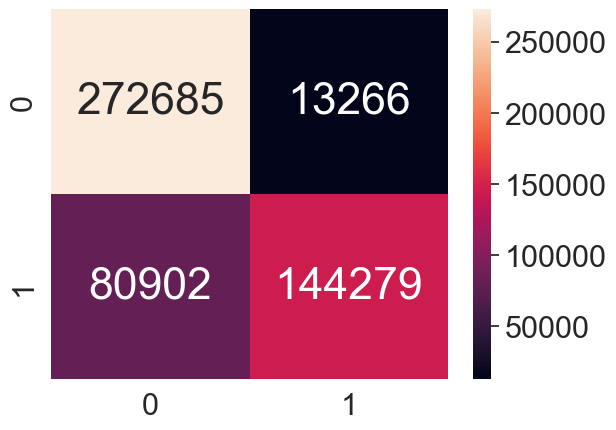

In [10]:
# Predict the Response corresponding to Predictors
y_train_pred = lr.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", lr.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 32})

<AxesSubplot:>

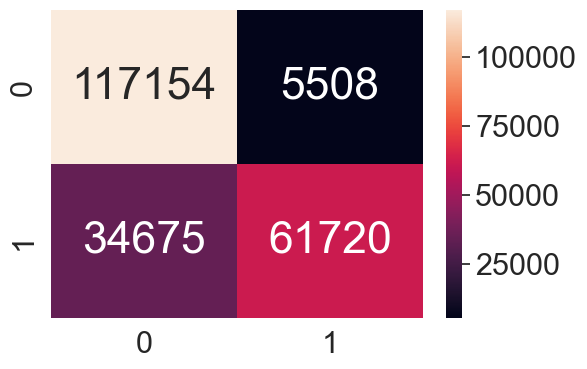

In [11]:
# Predict test dataset
y_test_pred = lr.predict(X_test)

# Print confusion matrix
f = plt.figure(figsize=(6,4))
sb.heatmap(cm:=confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 32})

### Accuracy metrics

In [12]:
# Get overall accuracy
print("Test Data")
print("Accuracy  :\t", lr.score(X_test, y_test))
print("")

# Get individual accuracy
tpTest = cm[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cm[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cm[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))

print("\nFPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

Test Data
Accuracy  :	 0.8165637254230634

TPR Test :	 0.6402821723118419
TNR Test :	 0.9550961177870897

FPR Test :	 0.04490388221291027
FNR Test :	 0.3597178276881581


In [14]:
# Print classification report
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

      benign       0.77      0.96      0.85    122662
    phishing       0.92      0.64      0.75     96395

    accuracy                           0.82    219057
   macro avg       0.84      0.80      0.80    219057
weighted avg       0.84      0.82      0.81    219057



### Conclusion
The results for the Logistic Regression model show that it might not be the best method to answer our question. There is a significant decrease in the accuracy of this model relative to the previous models.

Although there is no indication of overfitting, the model might perform better with other variables (or combination of). A remedy to model performance would be to test other combinations of variables.